In [1]:

import cv2
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200
from ssl_project.data_loaders import plot_utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from ssl_project.utils import to_np

from ssl_project.data_loaders.data_helper import UnlabeledDataset, LabeledDataset
from ssl_project.data_loaders.helper import collate_fn, draw_box

In [2]:
from PIL import Image
from ssl_project.data_loaders.helper import convert_map_to_lane_map, convert_map_to_road_map


In [3]:
from ssl_project.preprocessing.projections import create_label_data_road_only

In [17]:
LABELED_SCENE_INDEX

array([106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133])

In [2]:
import imageio

In [17]:
np.unique(cars_mask)

Array([0, 1], dtype=uint8)

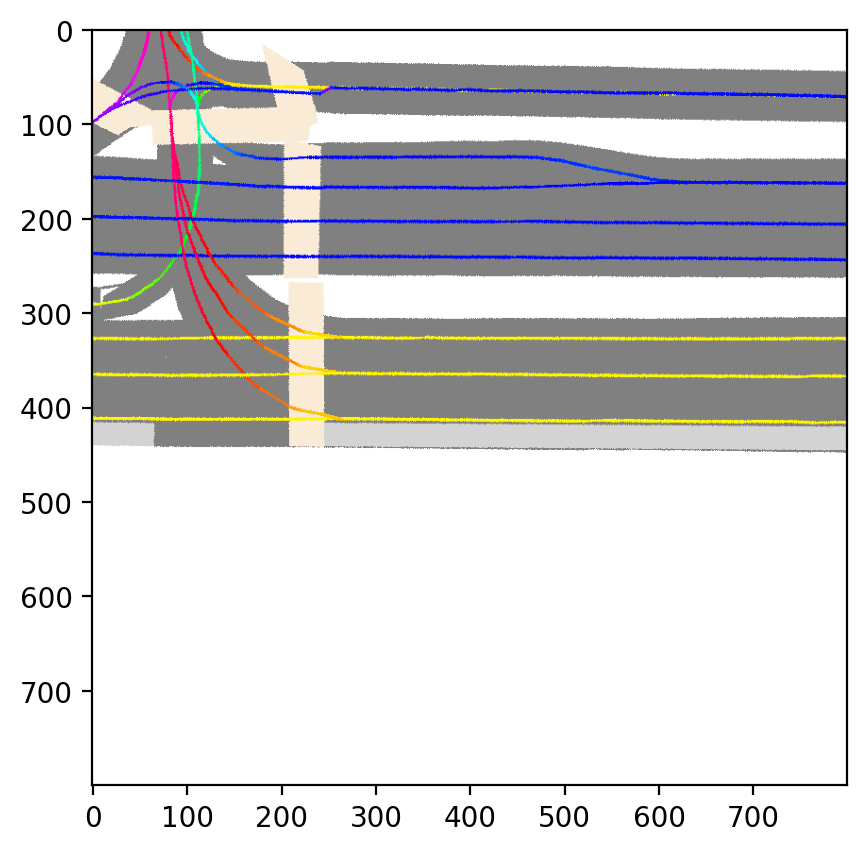

In [22]:
road_mask = imageio.imread("../data/scene_108/sample_85/ROAD_top_down_segm.png")
ego_image = imageio.imread("../data/scene_108/sample_85/ego.png")

plt.imshow(cars_mask, alpha=0.2)
plt.imshow(ego_image)

In [21]:
from ssl_project.constants import LABELED_SCENE_INDEX
for scene_id in LABELED_SCENE_INDEX:
    create_label_data_road_only(scene_id)

100%|██████████| 126/126 [00:11<00:00, 10.73it/s]


In [22]:
sample_id = 5
sample_path = f"../data/scene_{scene_id}/sample_{sample_id}"
road_image = cv2.imread(f"{sample_path}/ROAD_SEGM_CAM_FRONT.png", cv2.IMREAD_UNCHANGED)
photo = cv2.imread(f"{sample_path}/CAM_FRONT.jpeg", cv2.IMREAD_UNCHANGED)

In [13]:
# sample_path = f"../data/scene_{scene_id}/sample_{sample_id}"
# ego_image = cv2.imread(f"{sample_path}/ego.png", cv2.IMREAD_UNCHANGED)
# # ego_path = os.path.join(sample_path, 'ego.png')
# # ego_image = Image.open(ego_path)
# ego_image = torchvision.transforms.functional.to_tensor(ego_image)
# road_image = convert_map_to_road_map(ego_image)

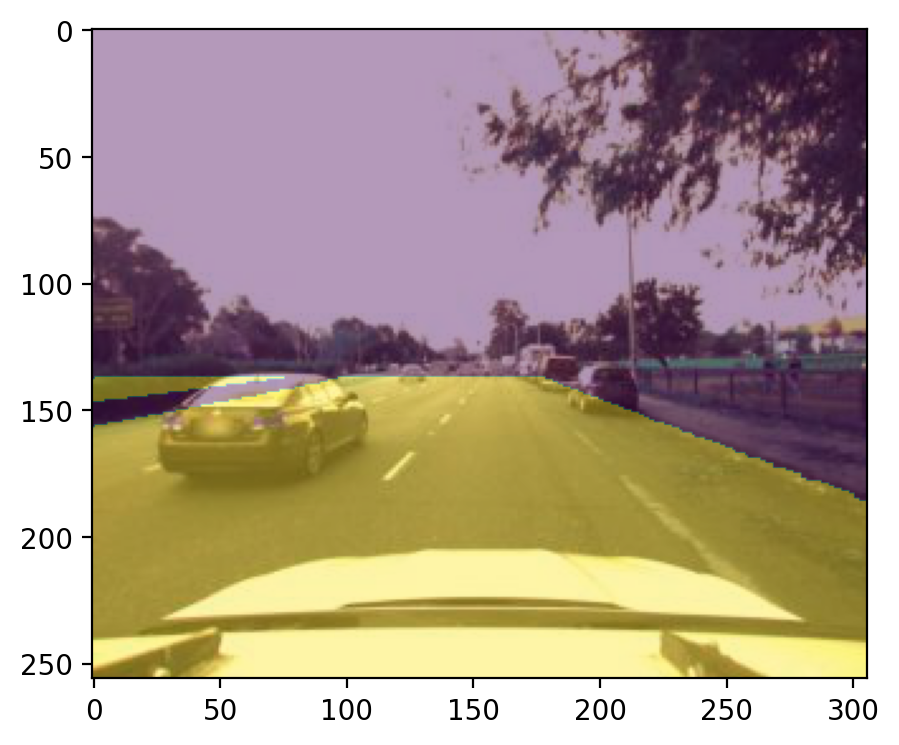

In [20]:
plt.imshow(photo)
plt.imshow(road_image, alpha=0.4)

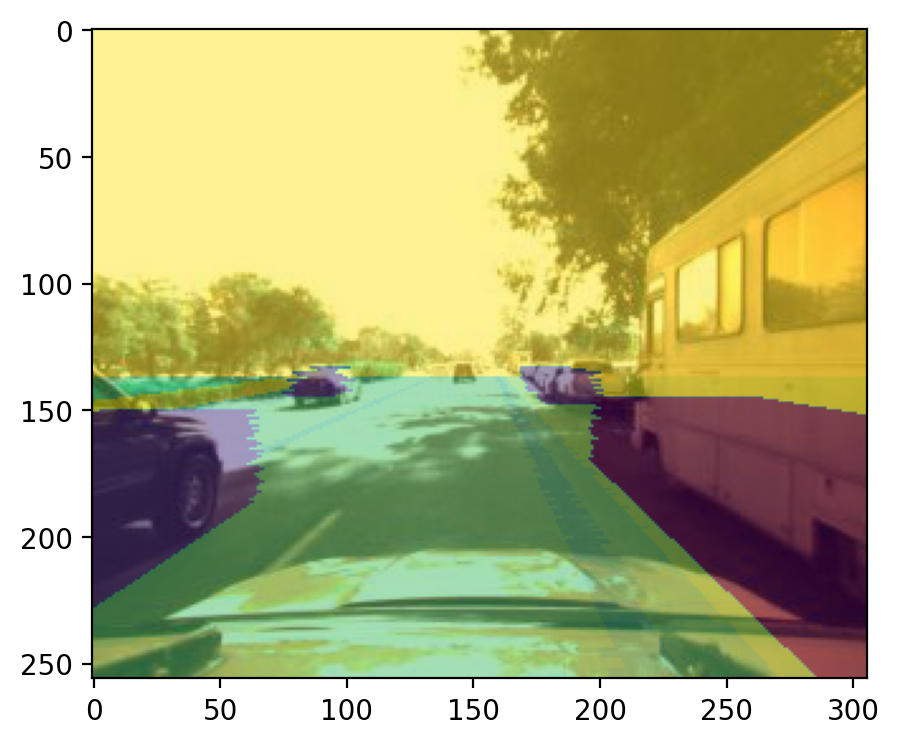

In [8]:
scene_id = 106
sample_id = 20
name = 'CAM_FRONT'
photo_hw = cv2.imread(f"../data/scene_{scene_id}/sample_{sample_id}/{name}.jpeg", cv2.IMREAD_UNCHANGED)
segm_hw = cv2.imread(f"../data/scene_{scene_id}/sample_{sample_id}/SEGM_{name}.png", cv2.IMREAD_UNCHANGED)
dist_hw = cv2.imread(f"../data/scene_{scene_id}/sample_{sample_id}/DIST_{name}.png", cv2.IMREAD_UNCHANGED)

fig, axis = plt.subplots(1, 1)

axis.imshow(photo_hw)
axis.imshow(segm_hw, alpha=0.5)
# axis.imshow(dist_hw, alpha=1)

In [3]:
labeled_trainset = LabeledDataset()

In [4]:
sample, target, road_image, extra = labeled_trainset[5]
sample.shape

torch.Size([6, 3, 256, 306])

In [239]:
im_src = np.array(road_image, dtype="float32")
im_src = np.broadcast_to(im_src[..., None], im_src.shape +(3,))

In [240]:
import matplotlib.cm as cm

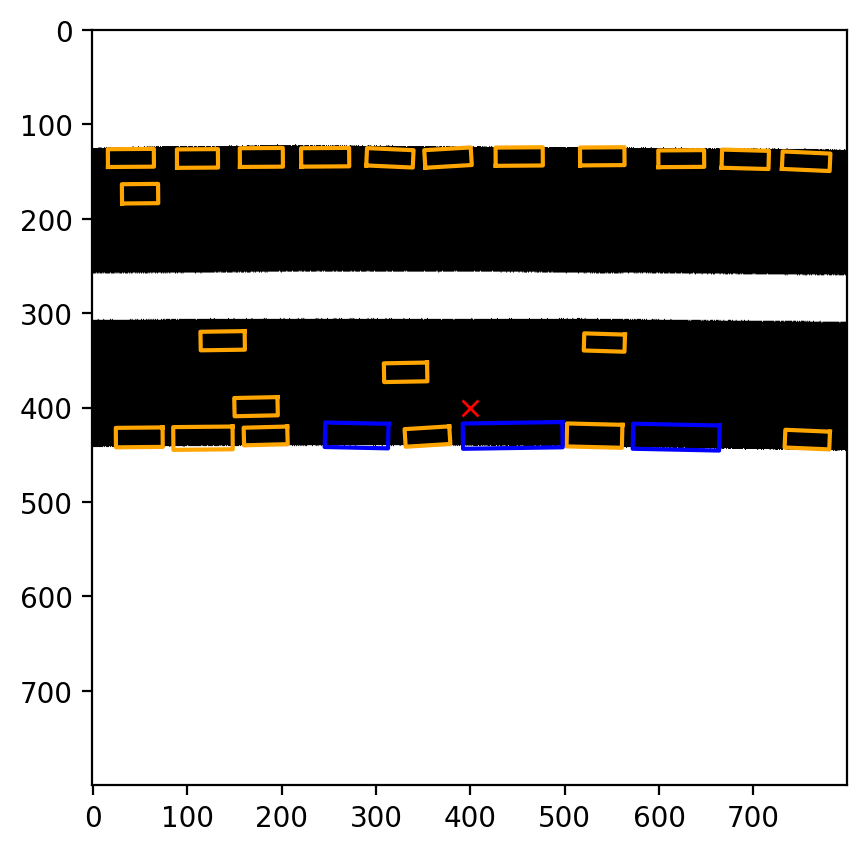

In [280]:
plot_utils.plot_bb(road_image, target)

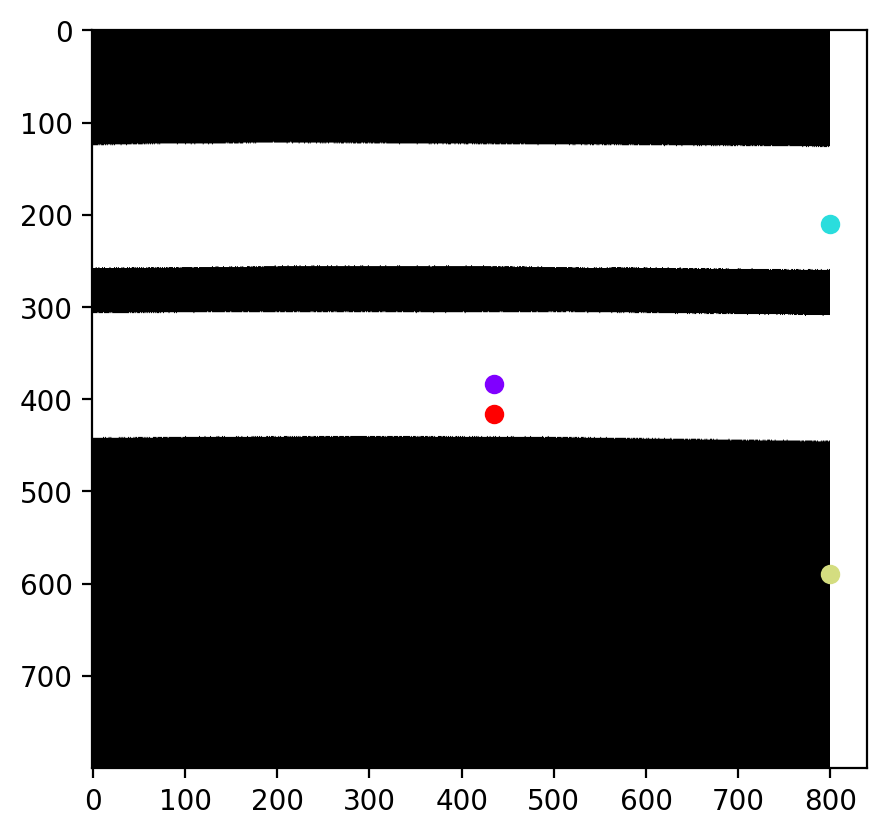

In [290]:
center = 400
front_x, back_x = 435, 800
offset_front_y, offset_back_y = (
    np.tan(alpha / 2) * (front_x - center), 
    np.tan(alpha / 2) * (back_x - center)
)

points_src = np.array([
    [front_x, 400 - offset_front_y],
    [back_x, 400 - offset_back_y],
    [back_x, 400 + offset_back_y],
    [front_x, 400 + offset_front_y],
])

# plot_utils.plot_bb(road_image, target, [7])
plt.imshow(im_src)

colors = cm.rainbow(np.linspace(0, 1, 4))
for (x, y), c in zip(points_src, colors):
    plt.scatter(x, y, color=c)
# plt.scatter(points_src[:, 0], points_src[:, 1])

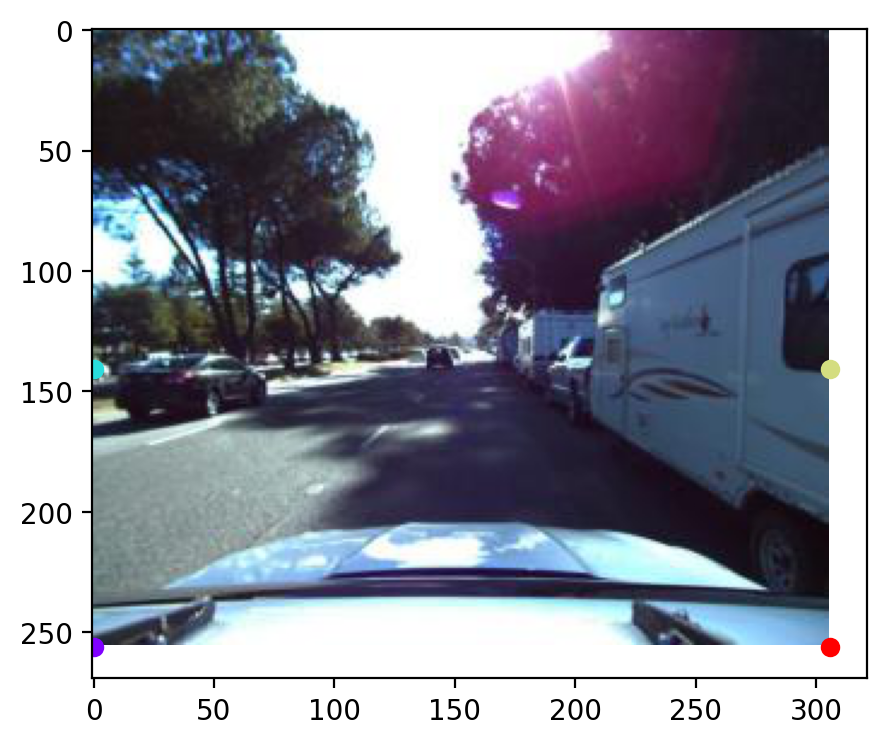

In [291]:
im_tgt = to_np(sample[1]).transpose(1, 2, 0)

offset_z = im_tgt.shape[0] * 0.55

points_tgt = np.array([
    [0, im_tgt.shape[0]],
    [0, offset_z],
    [im_tgt.shape[1], offset_z],
    [im_tgt.shape[1], im_tgt.shape[0]],
])

plt.imshow(im_tgt)

colors = cm.rainbow(np.linspace(0, 1, 4))
for (x, y), c in zip(points_tgt, colors):
    plt.scatter(x, y, color=c)
# plt.scatter(points_tgt[:, 0], points_tgt[:, 1])

In [292]:
from ssl_project.utils import to_np

In [293]:
points_src, points_tgt = points_src.astype("float32"), points_tgt.astype("float32")
M = cv2.getPerspectiveTransform(points_src, points_tgt)

In [294]:
# warped = cv2.warpPerspective(im_tgt,
#                              M, (im_tgt.shape[1], im_tgt.shape[0]))

In [295]:
warped = cv2.warpPerspective(im_src, M, (im_tgt.shape[1], im_tgt.shape[0] // 2))

In [296]:
warped.shape

(128, 306, 3)

In [297]:
warped.shape

(128, 306, 3)

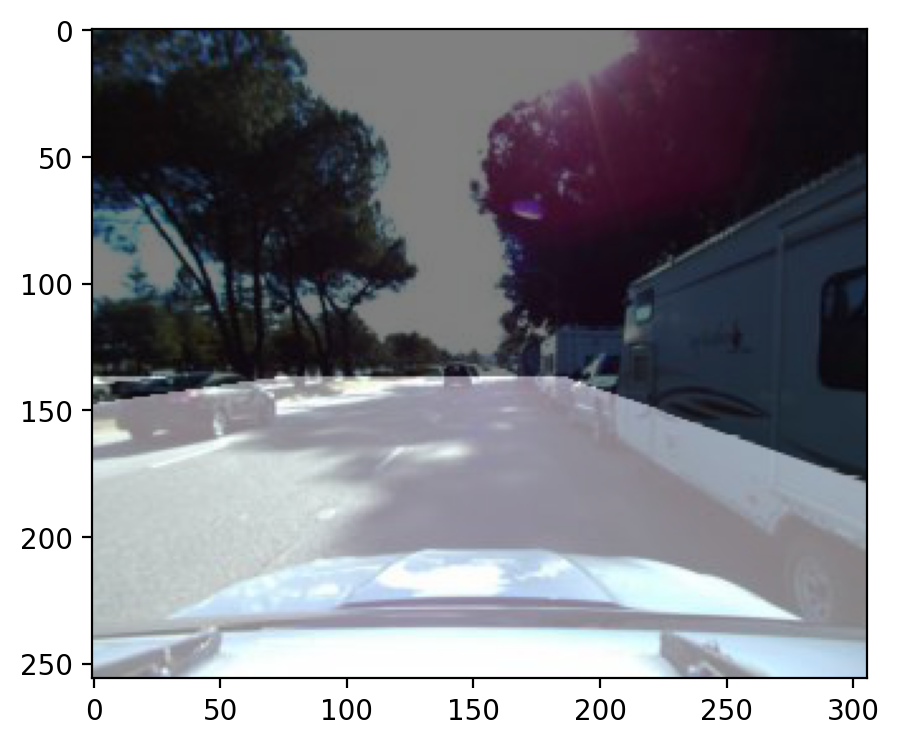

In [298]:
plt.imshow(im_tgt)

plt.imshow(np.concatenate((np.zeros_like(warped), warped[::-1, ::-1])), alpha=0.5)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

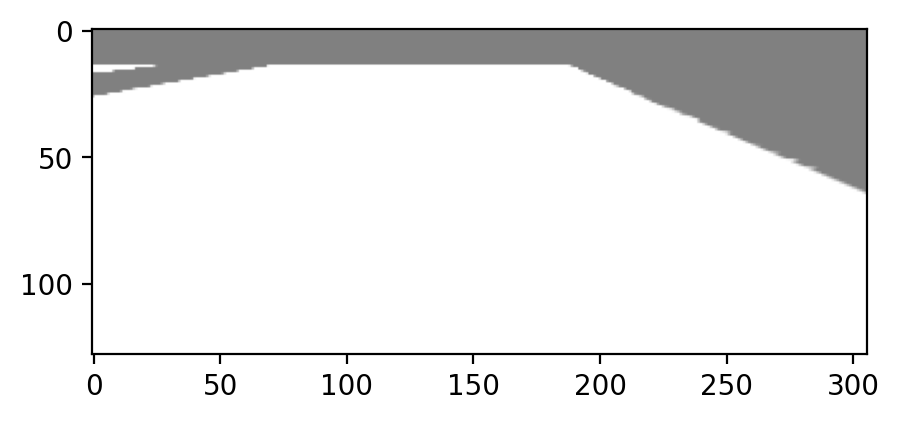

In [272]:
plt.imshow(, alpha=0.5)

## Data for oft

In [ ]:
# # Parse object data
# objects.append(utils.ObjectData(
#     classname=objdata[0],
#     dimensions=[
#         float(objdata[10]), float(objdata[8]), float(objdata[9])],
#     position=[float(p) for p in objdata[11:14]],
#     angle=float(objdata[14]),
#     score=float(objdata[15]) if len(objdata) == 16 else 1.
# ))

In [251]:
target["bounding_box"], target["category"]

(tensor([[[-19.3987, -19.3482, -24.0170, -23.9665],
          [ -2.0132,  -3.8799,  -2.1386,  -4.0052]],
 
         [[-32.6086, -32.5888, -37.5643, -37.5445],
          [ -2.1083,  -4.1705,  -2.1563,  -4.2185]],
 
         [[-11.0247, -10.9415,  -6.0968,  -6.0136],
          [ 25.6521,  27.4886,  25.4294,  27.2659]],
 
         [[-38.3921, -38.4055, -33.5203, -33.5336],
          [ 25.4865,  27.3718,  25.5215,  27.4068]],
 
         [[ -2.2287,  -2.1130,  -6.9615,  -6.8459],
          [ -1.9965,  -3.8602,  -2.2904,  -4.1542]],
 
         [[-24.4095, -24.4236, -19.8546, -19.8687],
          [ 25.4900,  27.4743,  25.5228,  27.5070]],
 
         [[-31.0742, -31.0880, -26.7283, -26.7422],
          [ 25.3965,  27.3508,  25.4277,  27.3820]],
 
         [[ 16.3925,  16.3364,  12.0776,  12.0215],
          [  7.7258,   5.9123,   7.8587,   6.0452]],
 
         [[  2.6902,   2.6765,   7.6871,   7.6734],
          [ 25.6106,  27.5429,  25.6466,  27.5789]],
 
         [[ 38.1131,  38.0328,  33.38

In [ ]:
extra['ego_image']